In [1]:
import numpy as np
import pandas as pd
import sys
import os
from tqdm import tqdm
import sklearn
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import seaborn as sns
from typing import Dict, Any
sns.set()
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))

Num GPUs Available:  0


In [2]:
!pip install lib/kaggle-rig-0.2.0.tar.gz
import krig
krig.seed_everything()

Processing ./lib/kaggle-rig-0.2.0.tar.gz
  Created wheel for kaggle-rig: filename=kaggle_rig-0.2.0-py3-none-any.whl size=6539 sha256=cb836bd6d7e61b4e91cbae14b95f1b73fa28fc46fc45f4383b27fee82f773275
  Stored in directory: /home/pankun/.cache/pip/wheels/03/99/72/07676e0abd65551d5261aee9360ad1c85fcaca1c409857a40a
Successfully built kaggle-rig
  Attempting uninstall: kaggle-rig
    Found existing installation: kaggle-rig 0.2.0
    Uninstalling kaggle-rig-0.2.0:
      Successfully uninstalled kaggle-rig-0.2.0


In [3]:
# Characters such as empty strings '' or numpy.inf are considered NA values
pd.set_option('use_inf_as_na', True)
pd.set_option('display.max_columns', 999)
pd.set_option('display.max_rows', 999)
sns.set(style="whitegrid")

In [4]:
MODEL = 'efficientnetb4'
EPOCHS = 1
LEARNING_RATE = 0.001
DROPOUT = 0.01
FOLDS = 10
BATCH_SIZE = 32
DATA = 'input/processed'
TARGET = ['fvc_last_3', 'fvc_last_2', 'fvc_last_1']
CONF = {
    'efficientnetb0': {
        'resolution': 224,
        'output_size': 1280,
    },
    'efficientnetb1': {
        'resolution': 240,
        'output_size': 0,
    },
    'efficientnetb2': {
        'resolution': 260,
        'output_size': 1408,
    },
    'efficientnetb3': {
        'resolution': 300,
        'output_size': 1536,
    },
    'efficientnetb4': {
        'resolution': 380,
        'output_size': 1792,
    },
    'efficientnetb5': {
        'resolution': 456,
        'output_size': 2048,
    },
    'efficientnetb6': {
        'resolution': 528,
        'output_size': 2304,
    },
    'efficientnetb7': {
        'resolution': 600,
        'output_size': 2560,
    },
}
INPUT_SHAPE = (CONF[MODEL]['resolution'], CONF[MODEL]['resolution'], 3)

In [5]:
data = pd.read_parquet(f'{DATA}/train.parquet')
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32684 entries, 0 to 32683
Data columns (total 17 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                32684 non-null  object 
 1   age                32684 non-null  uint8  
 2   sex                32684 non-null  object 
 3   smoking            32684 non-null  object 
 4   week_1             32684 non-null  int16  
 5   fvc_1              32684 non-null  uint16 
 6   percent_1          32684 non-null  float32
 7   fvc_last_1         32684 non-null  uint16 
 8   fvc_last_2         32684 non-null  uint16 
 9   fvc_last_3         32684 non-null  uint16 
 10  week_last_1        32684 non-null  int16  
 11  week_last_2        32684 non-null  int16  
 12  week_last_3        32684 non-null  int16  
 13  img                32684 non-null  object 
 14  lung_area          32684 non-null  int64  
 15  tissue_area        32684 non-null  int64  
 16  lung_tissue_ratio  326

In [6]:
data.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,img,lung_area,tissue_area,lung_tissue_ratio
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/1.png,1149,6314,0.181977
1,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/10.png,2691,6016,0.447307
2,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/11.png,2502,5735,0.436269
3,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/12.png,1102,8082,0.136352
4,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/13.png,2413,5101,0.473045


In [7]:
spl = sklearn.model_selection.GroupKFold(n_splits=FOLDS)
x = data['img']
y = data[TARGET]
groups = data['pid']
train = val = None
i = 0
for train_indices, test_indices in spl.split(x, y, groups):
    if i != 0:
        break
    train = data.iloc[train_indices]
    val = data.iloc[test_indices]
    i += 1


print(f'len(data)={len(data)}, len(train)={len(train)}, len(val)={len(val)}')

len(data)=32684, len(train)=29410, len(val)=3274


In [8]:
# Transfer learning from underlying pretrained model (freeze weights!)
# do not include output layer from pretrained model
pretrained = keras.applications.EfficientNetB4(
    include_top=False, input_shape=INPUT_SHAPE, pooling='max', weights='imagenet'
)
pretrained.trainable = False
kernel_initializer = keras.initializers.he_normal()
kernel_regularizer = keras.regularizers.l2(0.01) 
model = keras.models.Sequential()
model.add(pretrained)
model.add(keras.layers.BatchNormalization())
model.add(keras.layers.Dense(
    CONF[MODEL]['output_size'],
    activation="relu",
    kernel_initializer=kernel_initializer,
    kernel_regularizer=kernel_regularizer
))
model.add(keras.layers.Dropout(DROPOUT))
model.add(keras.layers.Dense(len(TARGET), name='output'))
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
batch_normalization (BatchNo (None, 1792)              7168      
_________________________________________________________________
dense (Dense)                (None, 1792)              3213056   
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 5379      
Total params: 20,899,426
Trainable params: 3,222,019
Non-trainable params: 17,677,407
_________________________________________________________________


In [9]:
callbacks = [
    keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=2, verbose=1, factor=0.5),
    keras.callbacks.EarlyStopping(monitor='val_loss', patience=4),
    keras.callbacks.ModelCheckpoint(filepath='best_model.h5', monitor='val_loss', save_best_only=True)
]
optimizer = keras.optimizers.Adam(learning_rate=LEARNING_RATE)
loss = keras.losses.MeanSquaredLogarithmicError()
rmse = keras.metrics.RootMeanSquaredError()
model.compile(loss=loss, optimizer=optimizer, metrics=[rmse])

In [10]:
target_size = (INPUT_SHAPE[0], INPUT_SHAPE[1])
color_mode='rgb'
class_mode='multi_output'
idg = keras.preprocessing.image.ImageDataGenerator()

train_gen = idg.flow_from_dataframe(
    dataframe = train,
    x_col='img',
    y_col=TARGET,
    directory=DATA,
    target_size=target_size,
    color_mode=color_mode,
    batch_size=BATCH_SIZE,
    shuffle=True,
    class_mode=class_mode
)

val_gen = idg.flow_from_dataframe(
    dataframe = val,
    x_col='img',
    y_col=TARGET,
    directory=DATA,
    target_size=target_size,
    color_mode=color_mode,
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode=class_mode
)

test_gen = idg.flow_from_dataframe(
    dataframe = data,
    x_col='img',
    y_col=TARGET,
    directory=DATA,
    target_size=target_size,
    color_mode=color_mode,
    shuffle=False,
    batch_size=BATCH_SIZE,
    class_mode=class_mode
)


Found 29410 validated image filenames.
Found 3274 validated image filenames.
Found 32684 validated image filenames.


In [35]:
history = model.fit(train_gen,
          epochs=EPOCHS, 
          validation_data=val_gen,#class_weight=class_weights_dict,
          callbacks=callbacks)

920/920 [==============================] - 13985s 15s/step - loss: 9.8212 - root_mean_squared_error: 2425.9404 - val_loss: 1.4450 - val_root_mean_squared_error: 1442.8523


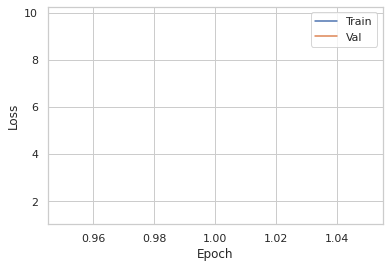

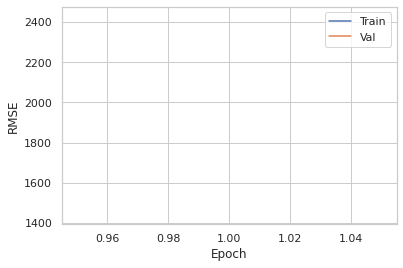

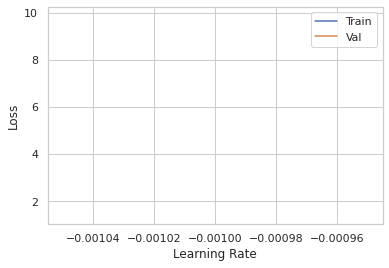

In [36]:
def plot_history(history):
    h = pd.DataFrame(history.history)
    h['epoch'] = history.epoch
    h['epoch'] = h['epoch'] + 1
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.plot(h['epoch'], h['loss'],label='Train')
    plt.plot(h['epoch'], h['val_loss'],label='Val')
    plt.legend()
    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.plot(h['epoch'], h['root_mean_squared_error'], label='Train')
    plt.plot(h['epoch'], h['val_root_mean_squared_error'], label='Val')
    plt.legend()
    plt.figure()
    plt.xlabel('Learning Rate')
    plt.ylabel('Loss')
    plt.plot(h['lr']*-1, h['loss'], label='Train')
    plt.plot(h['lr']*-1, h['val_loss'], label='Val')
    plt.legend()
    plt.show()


plot_history(history)

# Inference on images training set

In [11]:
model = keras.models.load_model('best_model.h5')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
efficientnetb4 (Functional)  (None, 1792)              17673823  
_________________________________________________________________
batch_normalization (BatchNo (None, 1792)              7168      
_________________________________________________________________
dense (Dense)                (None, 1792)              3213056   
_________________________________________________________________
dropout (Dropout)            (None, 1792)              0         
_________________________________________________________________
output (Dense)               (None, 3)                 5379      
Total params: 20,899,426
Trainable params: 3,222,019
Non-trainable params: 17,677,407
_________________________________________________________________


In [12]:
preds = model.predict(test_gen, use_multiprocessing=False, workers=4, verbose=1)
print(f'preds.shape={preds.shape}')

1022/1022 [==============================] - 18814s 18s/step
preds.shape=(32684, 3)


In [13]:
preds = preds.T
data['fvc_last_3_cv'] = preds[0]
data['fvc_last_2_cv'] = preds[1]
data['fvc_last_1_cv'] = preds[2]
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32684 entries, 0 to 32683
Data columns (total 20 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   pid                32684 non-null  object 
 1   age                32684 non-null  uint8  
 2   sex                32684 non-null  object 
 3   smoking            32684 non-null  object 
 4   week_1             32684 non-null  int16  
 5   fvc_1              32684 non-null  uint16 
 6   percent_1          32684 non-null  float32
 7   fvc_last_1         32684 non-null  uint16 
 8   fvc_last_2         32684 non-null  uint16 
 9   fvc_last_3         32684 non-null  uint16 
 10  week_last_1        32684 non-null  int16  
 11  week_last_2        32684 non-null  int16  
 12  week_last_3        32684 non-null  int16  
 13  img                32684 non-null  object 
 14  lung_area          32684 non-null  int64  
 15  tissue_area        32684 non-null  int64  
 16  lung_tissue_ratio  326

In [14]:
data.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,img,lung_area,tissue_area,lung_tissue_ratio,fvc_last_3_cv,fvc_last_2_cv,fvc_last_1_cv
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/1.png,1149,6314,0.181977,2242.349365,2239.727051,2237.690430
1,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/10.png,2691,6016,0.447307,2213.843506,2210.836182,2208.463379
2,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/11.png,2502,5735,0.436269,2359.399414,2357.509033,2355.927490
3,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/12.png,1102,8082,0.136352,2424.752441,2423.954346,2422.715088
4,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,ID00007637202177411956430/13.png,2413,5101,0.473045,2474.729492,2473.757568,2472.986572


In [15]:
data.drop(['img'], axis=1, inplace=True)

In [16]:
def set_dist(row, fvc_last_1_cv, fvc_last_2_cv, fvc_last_3_cv, lung_area, tissue_area, lung_tissue_ratio) -> None:
    quantiles = [0, 0.5, 0.75, 0.9, 0.95, 0.99, 1]
    s = pd.Series(fvc_last_1_cv)
    qs = s.quantile(quantiles).to_numpy()
    row['fvc_last_1_min'] = qs[0]
    row['fvc_last_1_p50'] = qs[1]
    row['fvc_last_1_p75'] = qs[2]
    row['fvc_last_1_p90'] = qs[3]
    row['fvc_last_1_p95'] = qs[4]
    row['fvc_last_1_p99'] = qs[5]
    row['fvc_last_1_max'] = qs[6]
    s = pd.Series(fvc_last_2_cv)
    qs = s.quantile(quantiles).to_numpy()
    row['fvc_last_2_min'] = qs[0]
    row['fvc_last_2_p50'] = qs[1]
    row['fvc_last_2_p75'] = qs[2]
    row['fvc_last_2_p90'] = qs[3]
    row['fvc_last_2_p95'] = qs[4]
    row['fvc_last_2_p99'] = qs[5]
    row['fvc_last_2_max'] = qs[6]
    s = pd.Series(fvc_last_3_cv)
    qs = s.quantile(quantiles).to_numpy()
    row['fvc_last_3_min'] = qs[0]
    row['fvc_last_3_p50'] = qs[1]
    row['fvc_last_3_p75'] = qs[2]
    row['fvc_last_3_p90'] = qs[3]
    row['fvc_last_3_p95'] = qs[4]
    row['fvc_last_3_p99'] = qs[5]
    row['fvc_last_3_max'] = qs[6]
    s = pd.Series(lung_area)
    qs = s.quantile(quantiles).to_numpy()
    row['lung_area_min'] = qs[0]
    row['lung_area_p50'] = qs[1]
    row['lung_area_p75'] = qs[2]
    row['lung_area_p90'] = qs[3]
    row['lung_area_p95'] = qs[4]
    row['lung_area_p99'] = qs[5]
    row['lung_area_max'] = qs[6]
    s = pd.Series(tissue_area)
    qs = s.quantile(quantiles).to_numpy()
    row['tissue_area_min'] = qs[0]
    row['tissue_area_p50'] = qs[1]
    row['tissue_area_p75'] = qs[2]
    row['tissue_area_p90'] = qs[3]
    row['tissue_area_p95'] = qs[4]
    row['tissue_area_p99'] = qs[5]
    row['tissue_area_max'] = qs[6]
    s = pd.Series(lung_tissue_ratio)
    qs = s.quantile(quantiles).to_numpy()
    row['lung_tissue_ratio_min'] = qs[0]
    row['lung_tissue_ratio_p50'] = qs[1]
    row['lung_tissue_ratio_p75'] = qs[2]
    row['lung_tissue_ratio_p90'] = qs[3]
    row['lung_tissue_ratio_p95'] = qs[4]
    row['lung_tissue_ratio_p99'] = qs[5]
    row['lung_tissue_ratio_max'] = qs[6]



rows = []
row: Dict[str, Any] = {}
prev = None
fvc_last_1_cv = []
fvc_last_2_cv = []
fvc_last_3_cv = []
lung_area = []
tissue_area = []
lung_tissue_ratio = []
for t in data.itertuples():
    # new patient
    if prev is not None and prev != t.pid:
        set_dist(row, fvc_last_1_cv, fvc_last_2_cv, fvc_last_3_cv, lung_area, tissue_area, lung_tissue_ratio)
        rows.append(row)
    if prev is None or prev != t.pid:
        row = {}
        fvc_last_1_cv = []
        fvc_last_2_cv = []
        fvc_last_3_cv = []
        lung_area = []
        tissue_area = []
        lung_tissue_ratio = []
        row['pid'] = t.pid
        row['age'] = t.age
        row['sex'] = t.sex
        row['smoking'] = t.smoking
        row['week_1'] = t.week_1
        row['fvc_1'] = t.fvc_1
        row['percent_1'] = t.percent_1
        row['fvc_last_1'] = t.fvc_last_1
        row['fvc_last_2'] = t.fvc_last_2
        row['fvc_last_3'] = t.fvc_last_3
        row['week_last_1'] = t.week_last_1
        row['week_last_2'] = t.week_last_2
        row['week_last_3'] = t.week_last_3
    prev = t.pid
    fvc_last_1_cv.append(t.fvc_last_1_cv)
    fvc_last_2_cv.append(t.fvc_last_2_cv)
    fvc_last_3_cv.append(t.fvc_last_3_cv)
    lung_area.append(t.lung_area)
    tissue_area.append(t.tissue_area)
    lung_tissue_ratio.append(t.lung_tissue_ratio)
    
# add the last patient!
if len(row) != 0:
    set_dist(row, fvc_last_1_cv, fvc_last_2_cv, fvc_last_3_cv, lung_area, tissue_area, lung_tissue_ratio)
    rows.append(row)



train = pd.DataFrame.from_records(rows)
assert len(train) == 174
train = train.astype({
    'pid': str,
    'age': np.uint8,
    'sex': str,
    'smoking': str,
    'week_1': np.int16,
    'fvc_1': np.uint16,
    'percent_1': np.float32,
    'fvc_last_1': np.uint16,
    'fvc_last_2': np.uint16,
    'fvc_last_3': np.uint16,
    'week_last_1': np.int16,
    'week_last_2': np.int16,
    'week_last_3': np.int16,
    'fvc_last_1_min': np.float32,
    'fvc_last_1_p50': np.float32,
    'fvc_last_1_p75': np.float32,
    'fvc_last_1_p90': np.float32,
    'fvc_last_1_p95': np.float32,
    'fvc_last_1_p99': np.float32,
    'fvc_last_1_max': np.float32,
    'fvc_last_2_min': np.float32,
    'fvc_last_2_p50': np.float32,
    'fvc_last_2_p75': np.float32,
    'fvc_last_2_p90': np.float32,
    'fvc_last_2_p95': np.float32,
    'fvc_last_2_p99': np.float32,
    'fvc_last_2_max': np.float32,
    'fvc_last_3_min': np.float32,
    'fvc_last_3_p50': np.float32,
    'fvc_last_3_p75': np.float32,
    'fvc_last_3_p90': np.float32,
    'fvc_last_3_p95': np.float32,
    'fvc_last_3_p99': np.float32,
    'fvc_last_3_max': np.float32,
    'lung_area_min': np.float32,
    'lung_area_p50': np.float32,
    'lung_area_p75': np.float32,
    'lung_area_p90': np.float32,
    'lung_area_p95': np.float32,
    'lung_area_p99': np.float32,
    'lung_area_max': np.float32,
    'tissue_area_min': np.float32,
    'tissue_area_p50': np.float32,
    'tissue_area_p75': np.float32,
    'tissue_area_p90': np.float32,
    'tissue_area_p95': np.float32,
    'tissue_area_p99': np.float32,
    'tissue_area_max': np.float32,
    'lung_tissue_ratio_min': np.float32,
    'lung_tissue_ratio_p50': np.float32,
    'lung_tissue_ratio_p75': np.float32,
    'lung_tissue_ratio_p90': np.float32,
    'lung_tissue_ratio_p95': np.float32,
    'lung_tissue_ratio_p99': np.float32,
    'lung_tissue_ratio_max': np.float32,
})
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 174 entries, 0 to 173
Data columns (total 55 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   pid                    174 non-null    object 
 1   age                    174 non-null    uint8  
 2   sex                    174 non-null    object 
 3   smoking                174 non-null    object 
 4   week_1                 174 non-null    int16  
 5   fvc_1                  174 non-null    uint16 
 6   percent_1              174 non-null    float32
 7   fvc_last_1             174 non-null    uint16 
 8   fvc_last_2             174 non-null    uint16 
 9   fvc_last_3             174 non-null    uint16 
 10  week_last_1            174 non-null    int16  
 11  week_last_2            174 non-null    int16  
 12  week_last_3            174 non-null    int16  
 13  fvc_last_1_min         174 non-null    float32
 14  fvc_last_1_p50         174 non-null    float32
 15  fvc_la

In [17]:
train.head()

,pid,age,sex,smoking,week_1,fvc_1,percent_1,fvc_last_1,fvc_last_2,fvc_last_3,week_last_1,week_last_2,week_last_3,fvc_last_1_min,fvc_last_1_p50,fvc_last_1_p75,fvc_last_1_p90,fvc_last_1_p95,fvc_last_1_p99,fvc_last_1_max,fvc_last_2_min,fvc_last_2_p50,fvc_last_2_p75,fvc_last_2_p90,fvc_last_2_p95,fvc_last_2_p99,fvc_last_2_max,fvc_last_3_min,fvc_last_3_p50,fvc_last_3_p75,fvc_last_3_p90,fvc_last_3_p95,fvc_last_3_p99,fvc_last_3_max,lung_area_min,lung_area_p50,lung_area_p75,lung_area_p90,lung_area_p95,lung_area_p99,lung_area_max,tissue_area_min,tissue_area_p50,tissue_area_p75,tissue_area_p90,tissue_area_p95,tissue_area_p99,tissue_area_max,lung_tissue_ratio_min,lung_tissue_ratio_p50,lung_tissue_ratio_p75,lung_tissue_ratio_p90,lung_tissue_ratio_p95,lung_tissue_ratio_p99,lung_tissue_ratio_max
0,ID00007637202177411956430,79,Male,Ex-smoker,-4,2315,58.253647,2057,2064,2000,57,41,29,2094.842529,2379.502686,2504.652832,2600.577881,2607.569824,2656.259033,2675.425537,2097.820312,2380.599609,2505.168457,2600.144775,2607.181641,2656.097412,2675.457520,2101.231201,2382.506348,2505.515625,2600.043701,2607.007080,2655.563232,2674.792969,670.0,1656.0,2391.25,2693.100098,2721.350098,2828.399902,2869.0,4255.0,6106.0,9372.75,11325.299805,12560.299805,13245.419922,13333.0,0.059491,0.256664,0.446996,0.568525,0.573278,0.626535,0.647630
1,ID00009637202177434476278,69,Male,Ex-smoker,8,3660,85.282875,3214,3390,3625,60,45,33,2400.511475,2958.102051,3091.000488,3166.162109,3222.469482,3319.070801,3450.082275,2402.069092,2955.877441,3088.014160,3162.992676,3218.813721,3314.536621,3444.784424,2402.285400,2953.018066,3084.434814,3159.297607,3214.609131,3310.036377,3438.939941,704.0,2156.5,2867.00,3206.899902,3339.449951,3478.419922,3523.0,9535.0,11885.5,16274.00,18535.300781,19007.099609,19512.429688,19734.0,0.039308,0.198787,0.255620,0.288663,0.300436,0.322504,0.335254
2,ID00010637202177584971671,60,Male,Ex-smoker,0,3523,94.724670,2518,2474,2993,54,37,25,2141.453613,2558.257812,2668.346436,2835.609131,2860.811035,2959.511475,2963.071777,2144.179443,2558.875977,2668.133057,2833.692627,2859.027344,2957.097656,2960.950684,2146.859131,2558.829590,2667.834717,2832.343750,2857.284424,2954.769287,2958.153564,232.0,1288.5,2612.75,3364.000000,3721.250000,4241.149902,4315.0,6774.0,10859.0,12289.00,15495.000000,16202.750000,16849.349609,16897.0,0.013873,0.115833,0.317440,0.443931,0.488324,0.562757,0.585732
3,ID00012637202177665765362,65,Male,Never smoked,33,3418,93.726006,2971,3231,3324,87,71,58,2413.611572,2969.650146,3654.516846,3865.494141,3906.264648,4100.998047,4138.594238,2414.878418,2967.251709,3648.433105,3858.191406,3898.387207,4091.735596,4129.174316,2416.050293,2965.389160,3642.410645,3850.513428,3890.452881,4083.124512,4120.473633,204.0,1129.0,1826.00,2223.399902,2491.600098,2976.679932,3089.0,5799.0,7015.0,8992.00,10425.000000,10657.200195,11110.839844,11371.0,0.024120,0.147254,0.295255,0.343806,0.391733,0.479589,0.516469
4,ID00014637202177757139317,56,Male,Ex-smoker,0,3807,90.076660,3027,3439,3221,54,37,26,2541.703369,3249.100830,3567.546387,3860.307129,3970.386475,4033.677002,4035.782471,2541.773193,3244.418457,3561.036133,3852.553223,3961.885986,4024.675293,4026.733398,2541.733643,3240.159180,3555.462891,3844.128906,3953.282715,4015.653564,4017.499268,516.0,1537.0,2958.50,3736.000000,4082.000000,5042.600098,5360.0,7745.0,10419.0,13426.50,17834.000000,18872.000000,19514.500000,19651.0,0.028359,0.143710,0.316701,0.432157,0.452699,0.625855,0.692059


In [18]:
train.to_parquet('output/cvtrain.parquet', index=False)